In [83]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import arrow

In [2]:
# 读取netCDF文件
ds = xr.open_dataset("H:/ecmwf/202301/era5-single-202301.nc")

In [160]:
ds_flux = xr.open_dataset("H:/ecmwf/202301/era5-flux-202301.nc")

In [161]:
print(ds_flux)

<xarray.Dataset>
Dimensions:    (longitude: 281, latitude: 361, time: 120)
Coordinates:
  * longitude  (longitude) float32 80.0 80.25 80.5 80.75 ... 149.5 149.8 150.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... -29.5 -29.75 -30.0
  * time       (time) datetime64[ns] 2023-01-11 ... 2023-01-15T23:00:00
Data variables:
    mslhf      (time, latitude, longitude) float32 ...
    msnlwrfcs  (time, latitude, longitude) float32 ...
    msnswrfcs  (time, latitude, longitude) float32 ...
    msshf      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-13 08:00:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...


In [175]:

# time_start = pd.to_datetime('2023-01-14 02:00')  + pd.Timedelta(-8,unit='h')
time_end = pd.to_datetime('2023-01-13 12:00')  + pd.Timedelta(-8,unit='h')
time_start = time_end - pd.Timedelta(48,unit='h')
ds_slice = ds.sel(time=slice(time_start, time_end))

# interp_step = 0.1
# ds_interp = ds_slice.interp(longitude=np.arange(ds_slice['longitude'].min(), ds_slice['longitude'].max()+interp_step, interp_step),
#                             latitude=np.arange(ds_slice['latitude'].max(), ds_slice['latitude'].min()-interp_step, -interp_step)
#                             )
# print(ds_interp)

In [134]:
target_lats, target_lons = np.meshgrid(np.arange(19.97,21.0,0.2), np.arange(109.96,111.13,0.2))
target_lats = target_lats.reshape(-1)
target_lons = target_lons.reshape(-1)

In [135]:
def getBackTrack(target_lat, target_lon,ds_slice):
    # 指定目标经纬度
    # target_lat = 20.284#20.0
    # target_lon = 110.583 #110.25

    # 找到最接近目标经纬度的网格点
    # lat_idx = ds_interp['latitude'].sel(latitude=target_lat, method='nearest').item()
    # lon_idx = ds_interp['longitude'].sel(longitude=target_lon, method='nearest').item()
    lat_idx = target_lat
    lon_idx = target_lon

    latlon_list = []
    # 反向追踪气团
    for t in range(len(ds_slice['time'])-1, -1, -1):
        # lat_idx = int(lat_idx)
        # lon_idx = int(lon_idx)
        # 计算气团的位移量
        # print(t, lat_idx, lon_idx)
        u_interp = ds_slice['u10'].interp(time=ds_slice['time'][t], latitude=lat_idx, longitude=lon_idx).item()
        v_interp =ds_slice['v10'].interp(time=ds_slice['time'][t], latitude=lat_idx, longitude=lon_idx).item()
        # print(f'u={u_interp.item()}, v={v_interp.item()}')
        du = u_interp * 3600  # 单位：米/小时
        dv = v_interp * 3600  # 单位：米/小时
        latlon_list.append([lat_idx, lon_idx,u_interp,v_interp,du,dv])


        # 计算新的经纬度
        new_lat = lat_idx - dv / 111000  # 单位：度
        new_lon = lon_idx - du / (111000 * np.cos(np.deg2rad(lat_idx)))  # 单位：度

        # 更新索引
        lat_idx = new_lat
        lon_idx = new_lon

        # 输出结果

        # print(f't={t}, lat={lat_idx}, lon={lon_idx}')
    return latlon_list

In [176]:
track_group = []
for index in range(len(target_lats)):
    target_lat=target_lats[index]
    target_lon=target_lons[index]
    i_track = getBackTrack(target_lat, target_lon,ds_slice)
    track_group.append(i_track)

<Figure size 432x288 with 0 Axes>

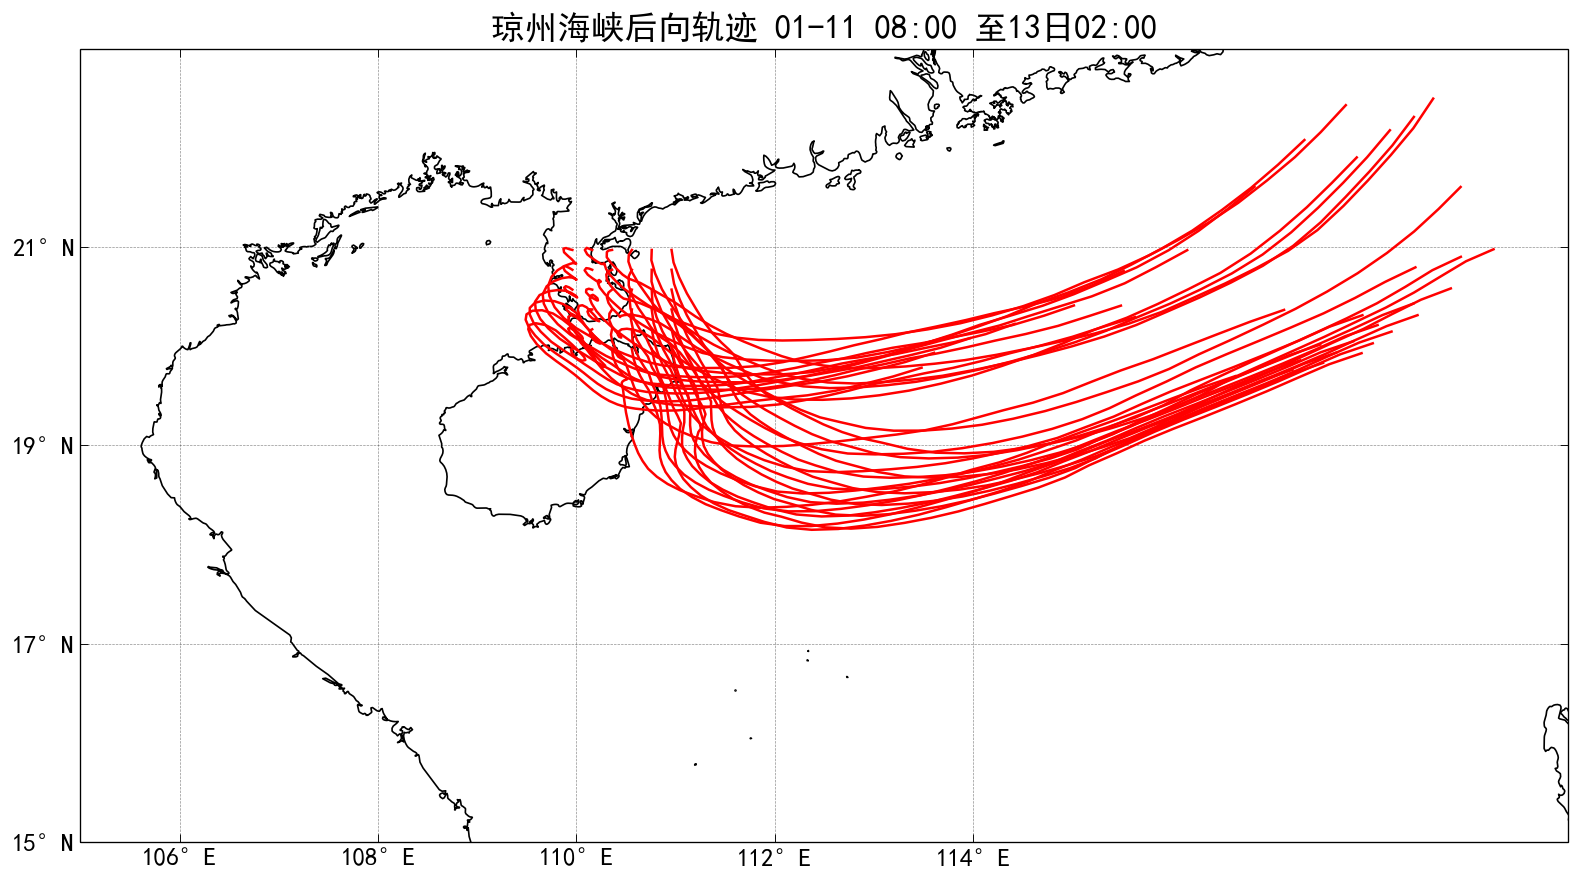

In [156]:
# Create a new plot
plt.clf()
figure = plt.figure(figsize=(16, 9), dpi=120)  # 加载画布
map_fig = plt.axes(projection=ccrs.PlateCarree())  # 设置投影方式
map_fig.set_extent([105, 120, 15, 23], crs=ccrs.PlateCarree())  # 设置绘图范围
map_fig.set_xticks([106, 108,110,112, 114])  # 需要显示的经度，一般可用np.arange
map_fig.set_yticks([15, 17, 19, 21])  # 需要显示的纬度
map_fig.xaxis.set_major_formatter(LongitudeFormatter())  # 将横坐标转换为经度格式
map_fig.yaxis.set_major_formatter(LatitudeFormatter())  # 将纵坐标转换为纬度格式
map_fig.tick_params(axis='both', labelsize=15, direction='in',
                       length=5, width=0.55, right=True, top=True)  # 修改刻度样式
map_fig.grid(linewidth=0.4, color='k', alpha=0.45, linestyle='--')  # 开启网格线
# Plot the data as a line
for i_track in track_group:
    track_data = np.array(i_track)
    track_lats = track_data[:, 0]
    track_lons = track_data[:, 1]
    map_fig.plot(track_lons, track_lats,color='r',)
# map_fig.barbs(track_lons, track_lats,track_u,track_v,
#                 barb_increments={'half':2,'full':4,'flag':20},
#                 length=6,sizes={'emptybarb':0})
# Add some map features
map_fig.coastlines()
# map_fig.gridlines()
start = pd.to_datetime(ds_slice['time'][0].values)
end = pd.to_datetime(ds_slice['time'][-1].values)
start_bj = arrow.get(start).shift(hours=8)
end_bj = arrow.get(end).shift(hours=8)
map_fig.set_title(f'琼州海峡后向轨迹 {start_bj.format("MM-DD HH:00")} 至{end_bj.format("DD日HH:00")}', fontsize=20)
# Show the plot
plt.show()

<Figure size 432x288 with 0 Axes>

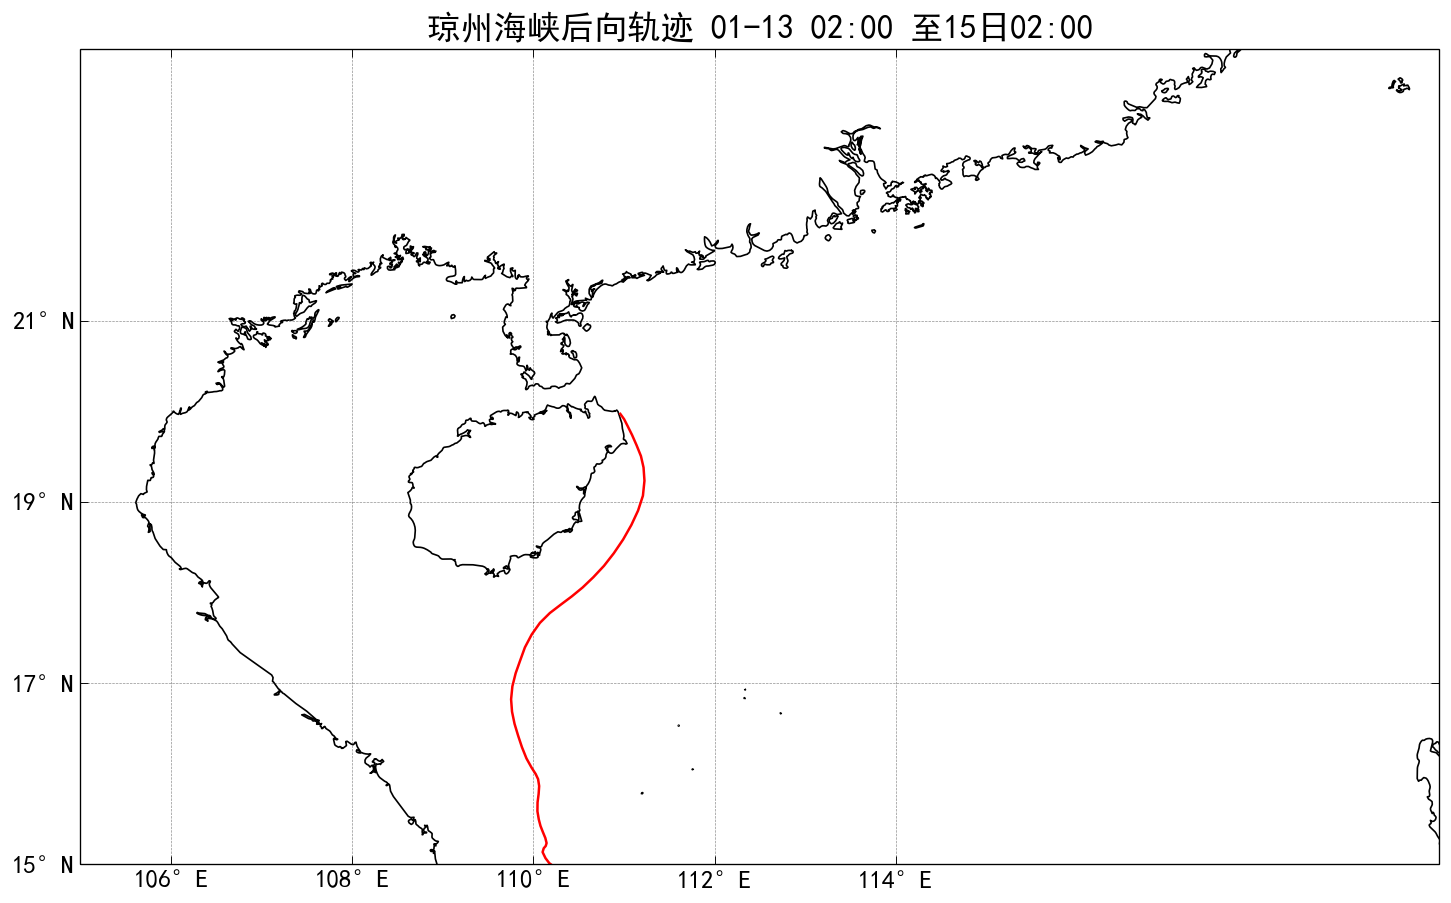

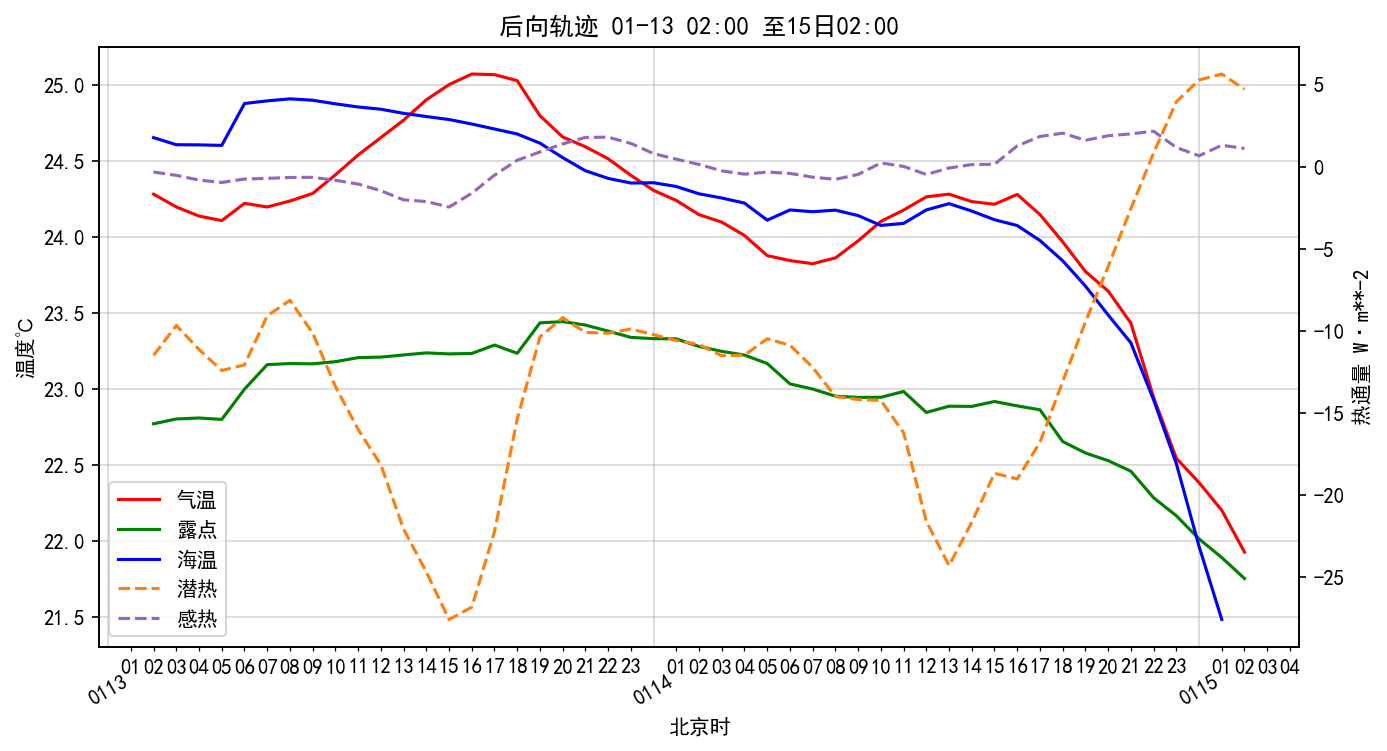

In [174]:
group_selected = 30 # third

# Create a new plot
plt.clf()
figure = plt.figure(figsize=(16, 9), dpi=120)  # 加载画布
map_fig = plt.axes(projection=ccrs.PlateCarree())  # 设置投影方式
map_fig.set_extent([105, 120, 15, 24], crs=ccrs.PlateCarree())  # 设置绘图范围
map_fig.set_xticks([106, 108,110,112, 114])  # 需要显示的经度，一般可用np.arange
map_fig.set_yticks([15, 17, 19, 21])  # 需要显示的纬度
map_fig.xaxis.set_major_formatter(LongitudeFormatter())  # 将横坐标转换为经度格式
map_fig.yaxis.set_major_formatter(LatitudeFormatter())  # 将纵坐标转换为纬度格式
map_fig.tick_params(axis='both', labelsize=15, direction='in',
                       length=5, width=0.55, right=True, top=True)  # 修改刻度样式
map_fig.grid(linewidth=0.4, color='k', alpha=0.45, linestyle='--')  # 开启网格线
# Plot the data as a line
i_track = track_group[group_selected]
track_data = np.array(i_track)
track_lats = track_data[:, 0]
track_lons = track_data[:, 1]
map_fig.plot(track_lons, track_lats,color='r',)
# map_fig.barbs(track_lons, track_lats,track_u,track_v,
#                 barb_increments={'half':2,'full':4,'flag':20},
#                 length=6,sizes={'emptybarb':0})
# Add some map features
map_fig.coastlines()
# map_fig.gridlines()
start = pd.to_datetime(ds_slice['time'][0].values)
end = pd.to_datetime(ds_slice['time'][-1].values)
start_bj = arrow.get(start).shift(hours=8)
end_bj = arrow.get(end).shift(hours=8)
map_fig.set_title(f'琼州海峡后向轨迹 {start_bj.format("MM-DD HH:00")} 至{end_bj.format("DD日HH:00")}', fontsize=20)
# Show the plot
plt.show()

i_track = track_group[group_selected]
track_data = np.array(i_track)
track_lats = track_data[:, 0]
track_lons = track_data[:, 1]

track_u = []
track_v = []
track_sst = []
track_d2m = []
track_t2m = []
track_lhf = []
track_shf = []
for index in range(len(ds_slice['time'])):
    ids = ds_slice.interp(time=ds_slice.time[len(ds_slice['time'])-1-index] ,latitude=track_lats[index],longitude=track_lons[index])
    ids_flux = ds_flux.interp(time=ds_slice.time[len(ds_slice['time'])-1-index] ,latitude=track_lats[index],longitude=track_lons[index])
    track_u.append(ids['u10'].item())
    track_v.append(ids['v10'].item())
    track_sst.append(ids['sst'].item())
    track_d2m.append(ids['d2m'].item())
    track_t2m.append(ids['t2m'].item())
    track_lhf.append(ids_flux['mslhf'].item())
    track_shf.append(ids_flux['msshf'].item())

track_u.reverse()
track_v.reverse()
track_sst.reverse()
track_d2m.reverse()
track_t2m.reverse()
track_lhf.reverse()
track_shf.reverse()
track_t2m = np.array(track_t2m)-273.15
track_d2m = np.array(track_d2m)-273.15
track_sst = np.array(track_sst)-273.15

start_time = pd.Timestamp('2023-01-14 18:00')
end_time = pd.Timestamp('2023-01-15 12:00')
fig = plt.figure(figsize=(8, 4), dpi=150)  # 添加画布
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylabel("温度")
line_t2m, = ax.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_t2m, color='r', markersize=4, label='2m气温', zorder=2)
line_td, = ax.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_d2m, color='g',  label='露点', zorder=3)
line_sst, = ax.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_sst, color='b', label='海温', zorder=4)


# 设置x轴主刻度格式
alldays = mdates.DayLocator()  # 主刻度为每天
ax.xaxis.set_major_locator(alldays)  # 设置主刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
# 设置副刻度格式
hoursLoc = mpl.dates.HourLocator(byhour=np.arange(0,24,1))  # 为6小时为1副刻度
ax.xaxis.set_minor_locator(hoursLoc)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
# 参数pad用于设置刻度线与标签间的距离
ax.tick_params(axis='x', which='major', pad=12, length=0)
ax.grid(True,alpha=0.5)
ax.set_xlabel("北京时")
ax.set_ylabel("温度℃")

# 绘制flux
ax2 = ax.twinx()
line_lhf, = ax2.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_lhf, color='tab:orange', markersize=4, label='潜热', zorder=5,linestyle='--')
line_shf, = ax2.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_shf, color='tab:purple', markersize=4, label='感热', zorder=6,linestyle='--')
ax2.set_ylabel("热通量 W·m**-2")
start = pd.to_datetime(ds_slice['time'][0].values)
end = pd.to_datetime(ds_slice['time'][-1].values)
start_bj = arrow.get(start).shift(hours=8)
end_bj = arrow.get(end).shift(hours=8)
ax.set_title(f'后向轨迹 {start_bj.format("MM-DD HH:00")} 至{end_bj.format("DD日HH:00")}')

plt.legend([line_t2m, line_td, line_sst, line_lhf,line_shf], ['气温', '露点', '海温','潜热','感热'])
plt.show()

<Figure size 432x288 with 0 Axes>

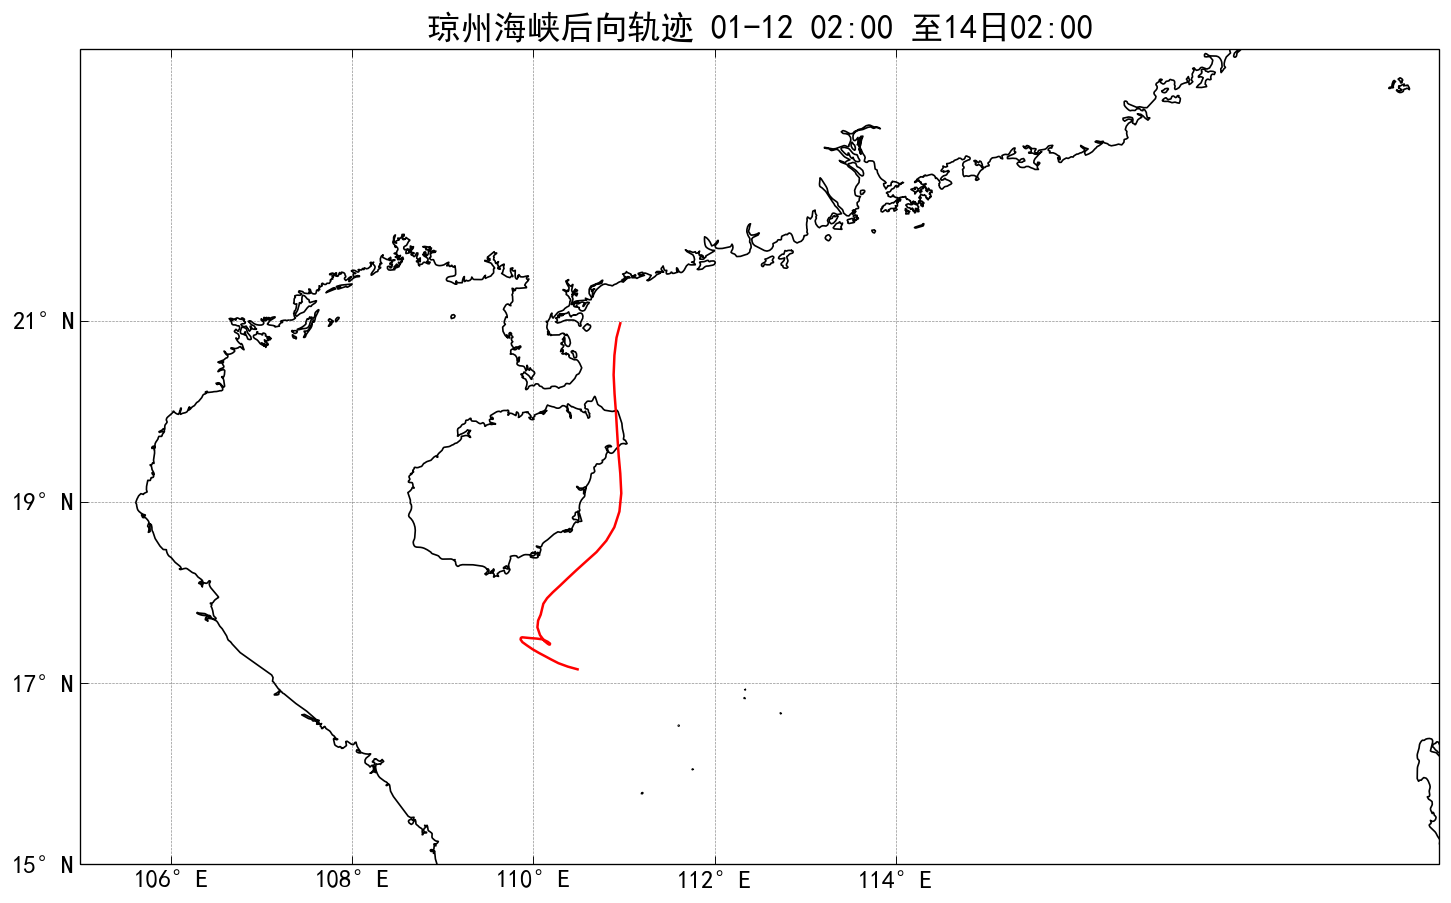

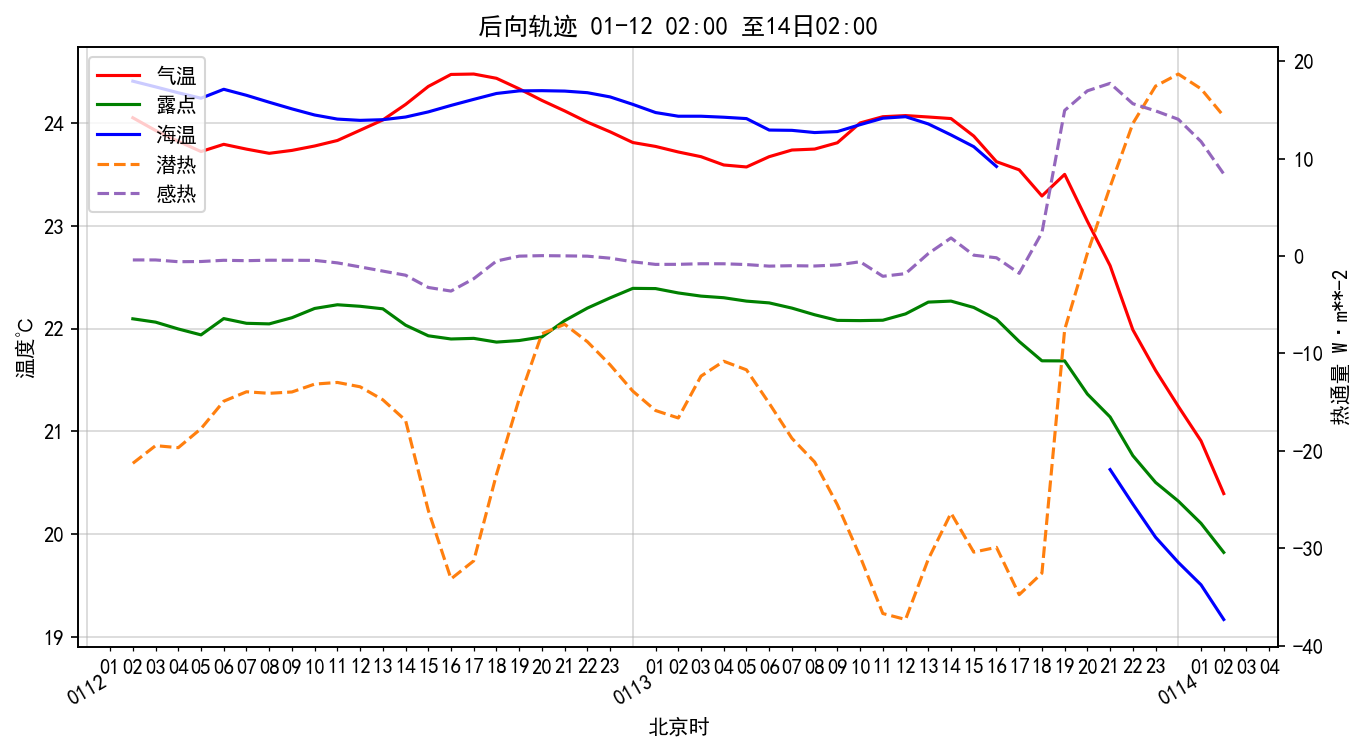

In [171]:
group_selected = 35 # second

# Create a new plot
plt.clf()
figure = plt.figure(figsize=(16, 9), dpi=120)  # 加载画布
map_fig = plt.axes(projection=ccrs.PlateCarree())  # 设置投影方式
map_fig.set_extent([105, 120, 15, 24], crs=ccrs.PlateCarree())  # 设置绘图范围
map_fig.set_xticks([106, 108,110,112, 114])  # 需要显示的经度，一般可用np.arange
map_fig.set_yticks([15, 17, 19, 21])  # 需要显示的纬度
map_fig.xaxis.set_major_formatter(LongitudeFormatter())  # 将横坐标转换为经度格式
map_fig.yaxis.set_major_formatter(LatitudeFormatter())  # 将纵坐标转换为纬度格式
map_fig.tick_params(axis='both', labelsize=15, direction='in',
                       length=5, width=0.55, right=True, top=True)  # 修改刻度样式
map_fig.grid(linewidth=0.4, color='k', alpha=0.45, linestyle='--')  # 开启网格线
# Plot the data as a line
i_track = track_group[group_selected]
track_data = np.array(i_track)
track_lats = track_data[:, 0]
track_lons = track_data[:, 1]
map_fig.plot(track_lons, track_lats,color='r',)
# map_fig.barbs(track_lons, track_lats,track_u,track_v,
#                 barb_increments={'half':2,'full':4,'flag':20},
#                 length=6,sizes={'emptybarb':0})
# Add some map features
map_fig.coastlines()
# map_fig.gridlines()
start = pd.to_datetime(ds_slice['time'][0].values)
end = pd.to_datetime(ds_slice['time'][-1].values)
start_bj = arrow.get(start).shift(hours=8)
end_bj = arrow.get(end).shift(hours=8)
map_fig.set_title(f'琼州海峡后向轨迹 {start_bj.format("MM-DD HH:00")} 至{end_bj.format("DD日HH:00")}', fontsize=20)
# Show the plot
plt.show()

i_track = track_group[group_selected]
track_data = np.array(i_track)
track_lats = track_data[:, 0]
track_lons = track_data[:, 1]

track_u = []
track_v = []
track_sst = []
track_d2m = []
track_t2m = []
track_lhf = []
track_shf = []
for index in range(len(ds_slice['time'])):
    ids = ds_slice.interp(time=ds_slice.time[len(ds_slice['time'])-1-index] ,latitude=track_lats[index],longitude=track_lons[index])
    ids_flux = ds_flux.interp(time=ds_slice.time[len(ds_slice['time'])-1-index] ,latitude=track_lats[index],longitude=track_lons[index])
    track_u.append(ids['u10'].item())
    track_v.append(ids['v10'].item())
    track_sst.append(ids['sst'].item())
    track_d2m.append(ids['d2m'].item())
    track_t2m.append(ids['t2m'].item())
    track_lhf.append(ids_flux['mslhf'].item())
    track_shf.append(ids_flux['msshf'].item())

track_u.reverse()
track_v.reverse()
track_sst.reverse()
track_d2m.reverse()
track_t2m.reverse()
track_lhf.reverse()
track_shf.reverse()
track_t2m = np.array(track_t2m)-273.15
track_d2m = np.array(track_d2m)-273.15
track_sst = np.array(track_sst)-273.15

start_time = pd.Timestamp('2023-01-14 18:00')
end_time = pd.Timestamp('2023-01-15 12:00')
fig = plt.figure(figsize=(8, 4), dpi=150)  # 添加画布
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylabel("温度")
line_t2m, = ax.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_t2m, color='r', markersize=4, label='2m气温', zorder=2)
line_td, = ax.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_d2m, color='g',  label='露点', zorder=3)
line_sst, = ax.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_sst, color='b', label='海温', zorder=4)


# 设置x轴主刻度格式
alldays = mdates.DayLocator()  # 主刻度为每天
ax.xaxis.set_major_locator(alldays)  # 设置主刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
# 设置副刻度格式
hoursLoc = mpl.dates.HourLocator(byhour=np.arange(0,24,1))  # 为6小时为1副刻度
ax.xaxis.set_minor_locator(hoursLoc)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
# 参数pad用于设置刻度线与标签间的距离
ax.tick_params(axis='x', which='major', pad=12, length=0)
ax.grid(True,alpha=0.5)
ax.set_xlabel("北京时")
ax.set_ylabel("温度℃")

# 绘制flux
ax2 = ax.twinx()
line_lhf, = ax2.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_lhf, color='tab:orange', markersize=4, label='潜热', zorder=5,linestyle='--')
line_shf, = ax2.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_shf, color='tab:purple', markersize=4, label='感热', zorder=6,linestyle='--')
ax2.set_ylabel("热通量 W·m**-2")
start = pd.to_datetime(ds_slice['time'][0].values)
end = pd.to_datetime(ds_slice['time'][-1].values)
start_bj = arrow.get(start).shift(hours=8)
end_bj = arrow.get(end).shift(hours=8)
ax.set_title(f'后向轨迹 {start_bj.format("MM-DD HH:00")} 至{end_bj.format("DD日HH:00")}')

plt.legend([line_t2m, line_td, line_sst, line_lhf,line_shf], ['气温', '露点', '海温','潜热','感热'])
plt.show()

<Figure size 432x288 with 0 Axes>

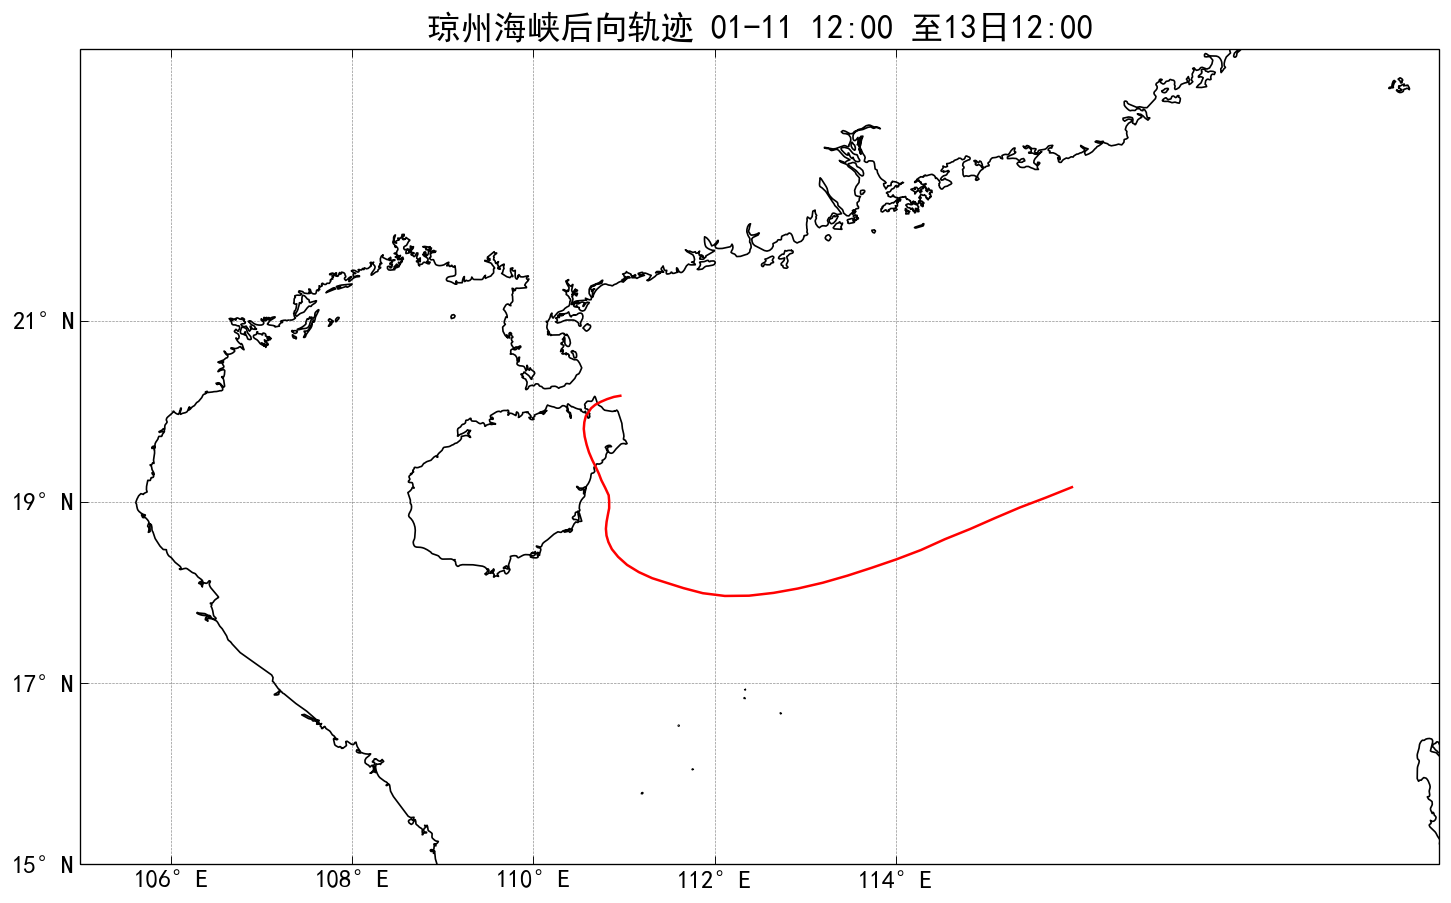

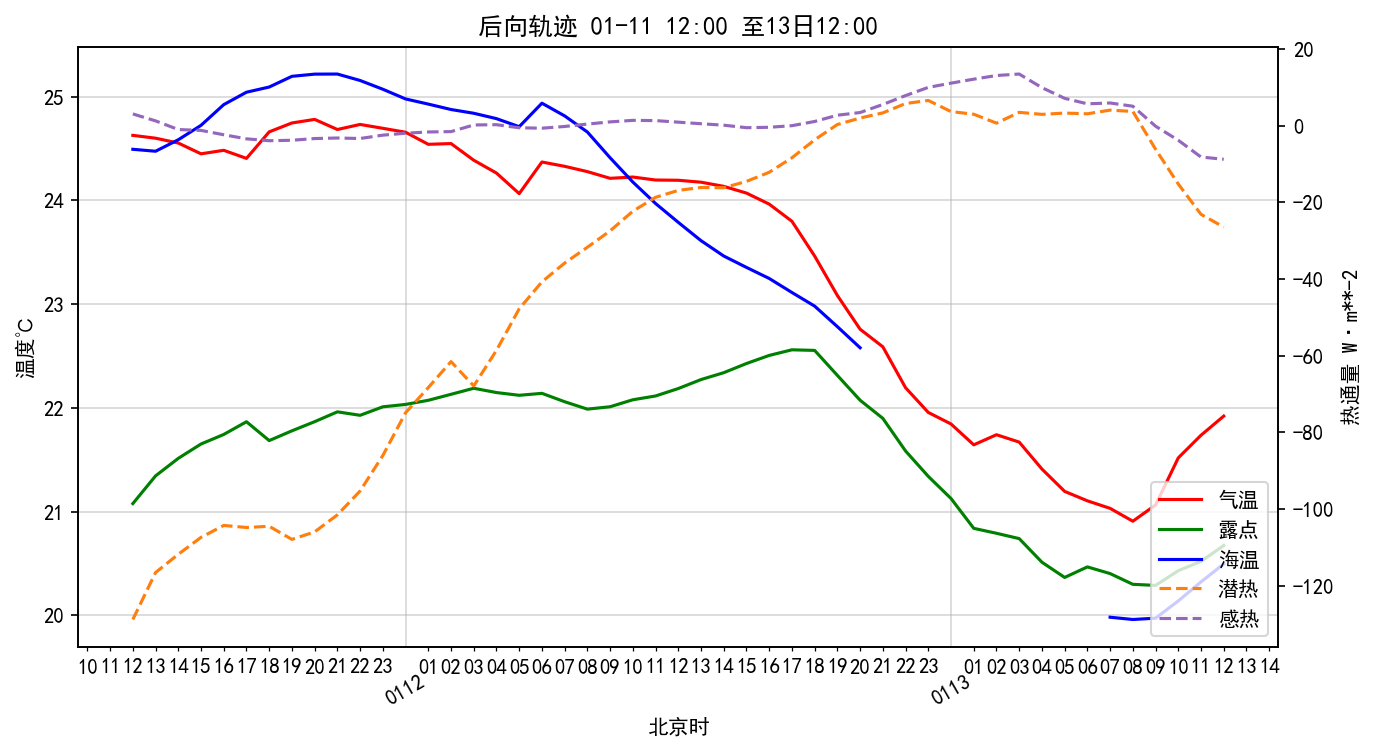

In [177]:
group_selected = 31

# Create a new plot
plt.clf()
figure = plt.figure(figsize=(16, 9), dpi=120)  # 加载画布
map_fig = plt.axes(projection=ccrs.PlateCarree())  # 设置投影方式
map_fig.set_extent([105, 120, 15, 24], crs=ccrs.PlateCarree())  # 设置绘图范围
map_fig.set_xticks([106, 108,110,112, 114])  # 需要显示的经度，一般可用np.arange
map_fig.set_yticks([15, 17, 19, 21])  # 需要显示的纬度
map_fig.xaxis.set_major_formatter(LongitudeFormatter())  # 将横坐标转换为经度格式
map_fig.yaxis.set_major_formatter(LatitudeFormatter())  # 将纵坐标转换为纬度格式
map_fig.tick_params(axis='both', labelsize=15, direction='in',
                       length=5, width=0.55, right=True, top=True)  # 修改刻度样式
map_fig.grid(linewidth=0.4, color='k', alpha=0.45, linestyle='--')  # 开启网格线
# Plot the data as a line
i_track = track_group[group_selected]
track_data = np.array(i_track)
track_lats = track_data[:, 0]
track_lons = track_data[:, 1]
map_fig.plot(track_lons, track_lats,color='r',)
# map_fig.barbs(track_lons, track_lats,track_u,track_v,
#                 barb_increments={'half':2,'full':4,'flag':20},
#                 length=6,sizes={'emptybarb':0})
# Add some map features
map_fig.coastlines()
# map_fig.gridlines()
start = pd.to_datetime(ds_slice['time'][0].values)
end = pd.to_datetime(ds_slice['time'][-1].values)
start_bj = arrow.get(start).shift(hours=8)
end_bj = arrow.get(end).shift(hours=8)
map_fig.set_title(f'琼州海峡后向轨迹 {start_bj.format("MM-DD HH:00")} 至{end_bj.format("DD日HH:00")}', fontsize=20)
# Show the plot
plt.show()

i_track = track_group[group_selected]
track_data = np.array(i_track)
track_lats = track_data[:, 0]
track_lons = track_data[:, 1]

track_u = []
track_v = []
track_sst = []
track_d2m = []
track_t2m = []
track_lhf = []
track_shf = []
for index in range(len(ds_slice['time'])):
    ids = ds_slice.interp(time=ds_slice.time[len(ds_slice['time'])-1-index] ,latitude=track_lats[index],longitude=track_lons[index])
    ids_flux = ds_flux.interp(time=ds_slice.time[len(ds_slice['time'])-1-index] ,latitude=track_lats[index],longitude=track_lons[index])
    track_u.append(ids['u10'].item())
    track_v.append(ids['v10'].item())
    track_sst.append(ids['sst'].item())
    track_d2m.append(ids['d2m'].item())
    track_t2m.append(ids['t2m'].item())
    track_lhf.append(ids_flux['mslhf'].item())
    track_shf.append(ids_flux['msshf'].item())

track_u.reverse()
track_v.reverse()
track_sst.reverse()
track_d2m.reverse()
track_t2m.reverse()
track_lhf.reverse()
track_shf.reverse()
track_t2m = np.array(track_t2m)-273.15
track_d2m = np.array(track_d2m)-273.15
track_sst = np.array(track_sst)-273.15

start_time = pd.Timestamp('2023-01-14 18:00')
end_time = pd.Timestamp('2023-01-15 12:00')
fig = plt.figure(figsize=(8, 4), dpi=150)  # 添加画布
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylabel("温度")
line_t2m, = ax.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_t2m, color='r', markersize=4, label='2m气温', zorder=2)
line_td, = ax.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_d2m, color='g',  label='露点', zorder=3)
line_sst, = ax.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_sst, color='b', label='海温', zorder=4)


# 设置x轴主刻度格式
alldays = mdates.DayLocator()  # 主刻度为每天
ax.xaxis.set_major_locator(alldays)  # 设置主刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
# 设置副刻度格式
hoursLoc = mpl.dates.HourLocator(byhour=np.arange(0,24,1))  # 为6小时为1副刻度
ax.xaxis.set_minor_locator(hoursLoc)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
# 参数pad用于设置刻度线与标签间的距离
ax.tick_params(axis='x', which='major', pad=12, length=0)
ax.grid(True,alpha=0.5)
ax.set_xlabel("北京时")
ax.set_ylabel("温度℃")

# 绘制flux
ax2 = ax.twinx()
line_lhf, = ax2.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_lhf, color='tab:orange', markersize=4, label='潜热', zorder=5,linestyle='--')
line_shf, = ax2.plot(ds_slice['time']+ pd.Timedelta(8,unit='h'), track_shf, color='tab:purple', markersize=4, label='感热', zorder=6,linestyle='--')
ax2.set_ylabel("热通量 W·m**-2")
start = pd.to_datetime(ds_slice['time'][0].values)
end = pd.to_datetime(ds_slice['time'][-1].values)
start_bj = arrow.get(start).shift(hours=8)
end_bj = arrow.get(end).shift(hours=8)
ax.set_title(f'后向轨迹 {start_bj.format("MM-DD HH:00")} 至{end_bj.format("DD日HH:00")}')

plt.legend([line_t2m, line_td, line_sst, line_lhf,line_shf], ['气温', '露点', '海温','潜热','感热'])
plt.show()